In [1]:
# EDA for covid19 mini project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [2]:
# import covid data
covid = pd.read_csv("../countries-aggregated.csv")
populations = pd.read_csv("../country_reference.csv")
owid = pd.read_csv("../owid-covid-data.csv")

covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37976 entries, 0 to 37975
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       37976 non-null  object
 1   Country    37976 non-null  object
 2   Confirmed  37976 non-null  int64 
 3   Recovered  37976 non-null  int64 
 4   Deaths     37976 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


In [3]:
# Extract countries from owid data

owid_countries = set(list(np.unique(owid['location'])))

In [4]:
# create global totals

covid_global = covid.sort_values(by=["Country", "Date"]).reset_index().drop(columns="index")

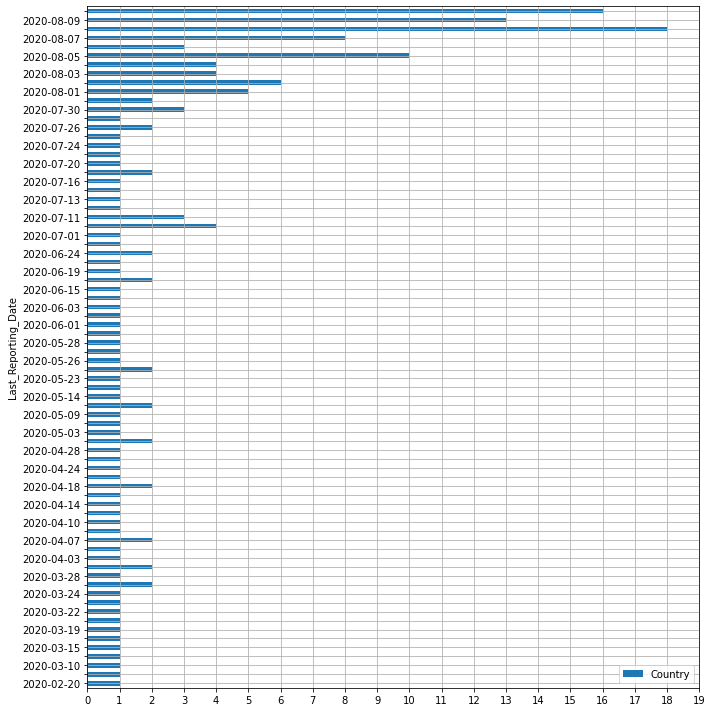

In [5]:
covid_global['Deaths_Delta'] = covid_global['Deaths'].diff()

covid_global['Deaths_Delta'].fillna(0, inplace=True)

last_report = covid_global[(covid_global['Deaths'] > 0) & (covid_global['Deaths_Delta'] == 0)]

last_report.index = pd.DatetimeIndex(last_report['Date'])

last_report = last_report.drop(columns=['Date'])

last_report_country = last_report.groupby('Country')['Deaths'].max().reset_index()

last_report_date = {
    'Country': [],
    'Last_Reporting_Date': []
}

for country in last_report_country['Country']:
    last_report_date['Country'].append(country)
    
    last_date = last_report[(last_report['Country'] == country) & (last_report['Deaths'] == last_report_country[last_report_country['Country']==country]['Deaths'].values[0])].index.values[0]
    
    last_report_date['Last_Reporting_Date'].append(last_date)
    
last_date_of_report = pd.DataFrame(last_report_date)

import matplotlib.dates as mdates

fig, axs = plt.subplots(1,1)

last_date_of_report.groupby('Last_Reporting_Date').count().plot.barh(ax=axs, figsize=(10,10))

labels=[]

for n, label in enumerate(axs.get_yticklabels()):
    labels.append(label.get_text()[:10])
    if n % 2 != 0:
        label.set_visible(False)
        
axs.set_yticklabels(labels)
        
plt.xticks(np.arange(0,20,1.0))
plt.grid()
        

# plt.locator_params(axis='x', nbins=50)
plt.tight_layout()

In [6]:
# Extract country populations

country_populations = populations[populations['Province_State'].isnull()][['Country_Region','Population']]

np.unique(country_populations['Country_Region'])

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [7]:
# add populations to covid data frame

covid_global['Population'] = [np.nan for _ in range(len(covid_global))]

for country in np.unique(country_populations['Country_Region']):
    pop = country_populations[country_populations['Country_Region'] == country]['Population'].values[0]
        
    for idx in covid_global[covid_global['Country'] == country].index.values:
        covid_global.at[idx, 'Population'] = pop

In [8]:
# generate list of countries

countries = list(np.unique(covid_global['Country']))
countries.remove('Diamond Princess')
countries.remove('MS Zaandam')

countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See

In [9]:
# Get positive_rates from owid and transfer them to intermediary data set to transfer to results data set

c = []
pr = []

pr_owid = owid[['location','positive_rate']].copy()
pr_owid.dropna(subset=['positive_rate'], inplace=True)
pr_owid = pr_owid.groupby('location')[['positive_rate']].mean().reset_index()

owid_countries = set(list(np.unique(pr_owid['location'])))

inter = set(countries).intersection(owid_countries)
inter.add('United States')

for country in inter:
    if country == 'United States':
        c.append('US')
    else: c.append(country)
    
    po_rt = pr_owid[pr_owid['location'] == country]['positive_rate'].values[0]
    
    pr.append(po_rt)
    
positive_rates = pd.DataFrame({
    'Country': c,
    'Positive_Rate': pr
})

for country in countries:
    if country not in owid_countries:
        positive_rates = positive_rates.append({
            'Country': country,
            'Positive_Rate': positive_rates['Positive_Rate'].median()
        }, ignore_index=True)

In [10]:
np.unique(owid[['location','gdp_per_capita']]['location'])

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

In [11]:
# Get gdp from owid and transfer them to intermediary data set to transfer to results data set

c = []
gdp = []

gdp_owid = owid[['location','gdp_per_capita']].copy()
gdp_owid.dropna(subset=['gdp_per_capita'], inplace=True)
gdp_owid = gdp_owid.groupby('location')[['gdp_per_capita']].mean().reset_index()

gdp_owid

owid_countries = set(list(np.unique(gdp_owid['location'])))

inter = set(countries).intersection(owid_countries)
inter.add('United States')

for country in inter:
    if country == 'United States':
        c.append('US')
    else: c.append(country)
    
    po_rt = gdp_owid[gdp_owid['location'] == country]['gdp_per_capita'].values[0]
    
    gdp.append(po_rt)
    
gdp_rates = pd.DataFrame({
    'Country': c,
    'GDP': gdp
})

for country in countries:
    
    
    if country not in owid_countries:
        gdp_rates = gdp_rates.append({
            'Country': country,
            'GDP': np.nan
        }, ignore_index=True)

In [12]:
# generate model for recovered and deaths for each country

confirmed_rate = []
deaths_rate = []
predicted_infection_rate = []
gdps = []
rtwos = []
c = []



for country in countries:
    df = covid_global[covid_global['Country'] == country]
    
    population = country_populations[country_populations['Country_Region'] == country]['Population'].values[0]
    
    c.append(country)
    
    for col in ['Confirmed','Deaths']:
        y = df.set_index('Date')[[col]].fillna(0)
        y.index.name='Date'

        y.index = pd.DatetimeIndex(y.index)
        
        window = 25
        num_samples = len(y) - window
        middle = num_samples + window - 1

        X_mat = []
        y_mat = []

        for i in range(num_samples):
            X_mat.insert(0, [item for sub in y.iloc[middle - i - window:middle - i].values for item in sub])
            y_mat.insert(0, y.iloc[middle - i: middle - i + 1].values[0][0])
            
        X_mat = np.array(X_mat)
        y_mat = np.array(y_mat)

        LR = LinearRegression(fit_intercept=False)

        split_idx = int(len(X_mat) * 0.7)

        X_train, X_test = X_mat[:split_idx], X_mat[split_idx:-1]
        y_train, y_test = y_mat[:split_idx], y_mat[split_idx:-1]

        LR.fit(X_train, y_train)

        y_pred = LR.predict(X_test)
        

        last_prediction = LR.predict([X_mat[-1]])[0]

        rate = last_prediction/population
        
        if country=='US':
            print(country, rate, last_prediction)

        if col == 'Confirmed':
            confirmed_rate.append(rate)
        else:
            rtwos.append(LR.score(X_test, y_test))
            deaths_rate.append(rate)
            predicted_infection_rate.append(positive_rates[ \
            positive_rates['Country'] == country]['Positive_Rate'].values[0])
            gdps.append(gdp_rates[gdp_rates['Country'] == country]['GDP'].values[0])
                
rates = pd.DataFrame({
    'Country': c,
    'Confirmed_Rate': confirmed_rate,
    'Death_Rate': deaths_rate,
    'Positive_Rate': predicted_infection_rate,
    'GDP': gdps,
    'Model_R2_Score': rtwos
})

rates.dropna(subset=['GDP'], inplace=True)

US 0.015457618674413141 5092764.168690285
US 0.0004960892931750761 163444.6954584896


In [13]:
rates[rates['Country']=='US']

Country  Confirmed_Rate  Death_Rate  Positive_Rate        GDP  \
172      US        0.015458    0.000496       0.097735  54225.446   

     Model_R2_Score  
172        0.999725

In [14]:
rates[(rates['Model_R2_Score'] == rates['Model_R2_Score'].max()) | (rates['Model_R2_Score'] == rates['Model_R2_Score'].min())]

Country  Confirmed_Rate  Death_Rate  \
19                             Bhutan        0.000143    0.000000   
30                           Cambodia        0.000015    0.000000   
33           Central African Republic        0.000312    0.000119   
49                           Dominica        0.000250    0.000000   
55                            Eritrea        0.000082    0.000000   
68                            Grenada        0.000212    0.000000   
94                               Laos        0.000003    0.000000   
114                          Mongolia        0.000089    0.000000   
140             Saint Kitts and Nevis        0.000320    0.000000   
141                       Saint Lucia        0.000136    0.000000   
142  Saint Vincent and the Grenadines        0.000523    0.000000   
148                        Seychelles        0.001289    0.000000   

     Positive_Rate        GDP  Model_R2_Score  
19        0.041136   8708.597        1.000000  
30        0.041136   3645.070        1.000000  
33        0.041136    661.240     -902.002914  
49        0.041136   9673.367        1.000000  
55        0.041136   1510.459        1.000000  
68        0.041136  13593.877        1.000000  
94        0.041136   6397.360        1.000000  
114       0.041136  11840.846        1.000000  
140       0.041136  24654.385        1.000000  
141       0.041136  12951.839        1.000000  
142       0.041136  10727.146        1.000000  
148       0.041136  26382.287        1.000000

In [15]:
# Danger Score and scaling

from sklearn.preprocessing import MinMaxScaler

rates['Danger_Score'] = rates['Positive_Rate'] * rates['Death_Rate']

rates['Danger_Score_Norm'] = MinMaxScaler((1,5)).fit_transform(np.array(rates['Danger_Score']).reshape(-1,1))

$A = Chance\ of\ Getting\ Covid\ In\ Country$

$B = Chance\ of\ Dying\ From\ Covid\ In\ Country\\$
$Danger\ Score=P(A\ and\ B) = P(A) * P(B)$

In [16]:
# best and worst danger score countries

rates[(rates['Danger_Score'] == rates['Danger_Score'].max()) | (rates['Danger_Score'] == rates['Danger_Score'].min())][['Country','GDP','Danger_Score_Norm']]

Country        GDP  Danger_Score_Norm
35        Chile  22767.037                5.0
117  Mozambique   1136.103                1.0

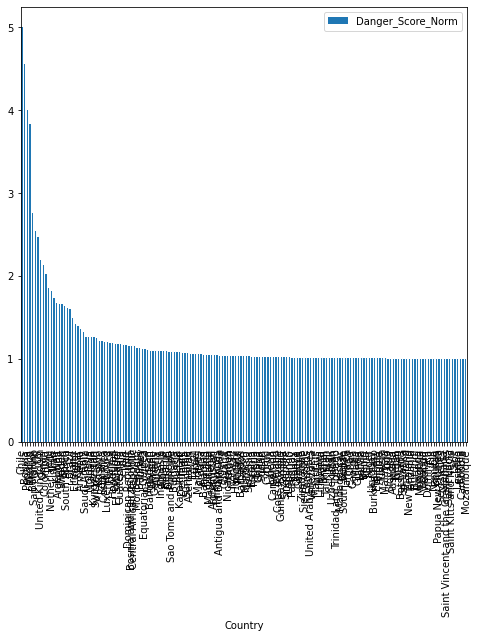

In [17]:
rates.sort_values(by='Danger_Score', ascending=False).set_index('Country')[['Danger_Score_Norm']].plot.bar(figsize=(8,8))

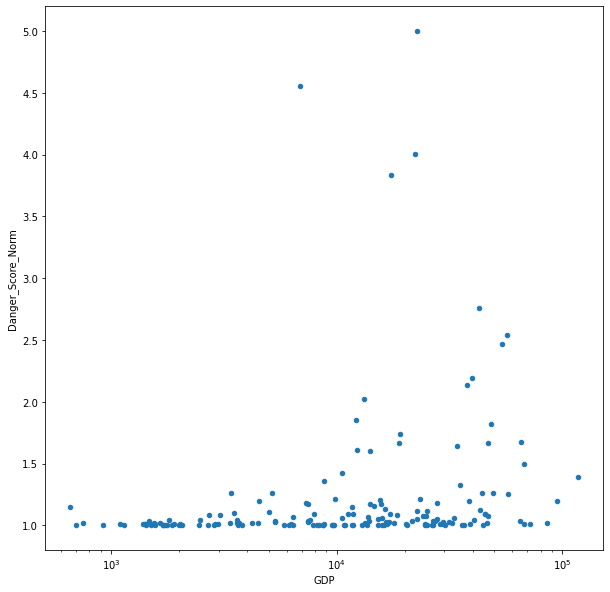

In [18]:
fig, ax = plt.subplots()

rates.plot.scatter(ax=ax, x='GDP', y='Danger_Score_Norm', figsize=(10,10))

ax.set_xscale('log')

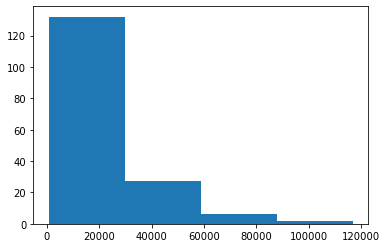

(array([132.,  27.,   6.,   2.]),
 array([   661.24,  29729.83,  58798.42,  87867.01, 116935.6 ]))

In [19]:
(n, bins, patches) = plt.hist(rates['GDP'], bins=4)

plt.show()

n, bins

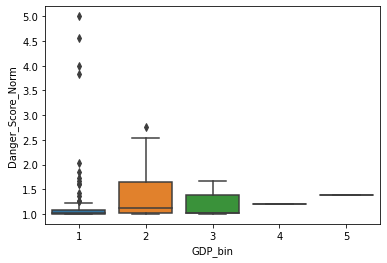

In [20]:
import seaborn as sns

danger_scores = np.around((np.array(rates['Danger_Score_Norm'])))

rates['Danger_Score_Category'] = danger_scores
# rates['GDP_bin'] = np.digitize(np.array(rates['GDP']), np.insert(bins, 0, 0.0)) - 1
rates['GDP_bin'] = np.digitize(np.array(rates['GDP']), bins)

fig, axs = plt.subplots()

sns.boxplot(x='GDP_bin', y='Danger_Score_Norm', data=rates)

plt.show()

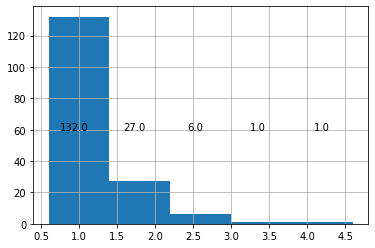

In [21]:
n, _, _ = plt.hist(rates['GDP_bin'], bins=5, align='left')
for idx, val in enumerate(n):
    plt.annotate(str(val), ((idx+0.75)-idx/6, 60))
plt.grid()
plt.show()

In [26]:
# US Danger Score
rates[rates['Country'] == 'US'].set_index('Country').loc[:, 'GDP':]

GDP  Model_R2_Score  Danger_Score  Danger_Score_Norm  \
Country                                                               
US       54225.446        0.999725      0.000048           2.469222   

         Danger_Score_Category  GDP_bin  
Country                                  
US                         2.0        2